In [1]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *

from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *

from pref_voting.utility_profiles import UtilityProfile

from pref_voting.generate_utility_profiles import *
from pref_voting.generate_utility_profiles import *
from pref_voting.utility_methods import *

from pref_voting.spatial_profiles import SpatialProfile
from pref_voting.generate_spatial_profiles import *
from pref_voting.utility_functions import *
from tqdm.notebook import tqdm


<AxesSubplot: >

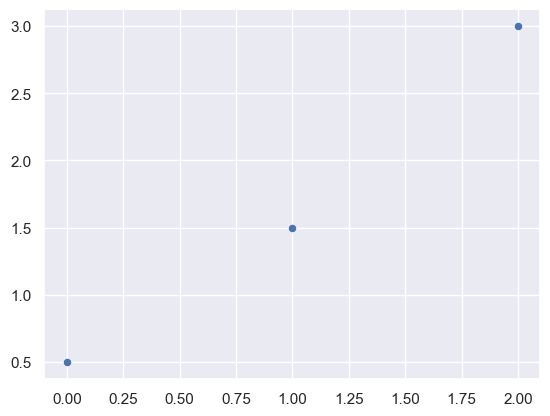

In [2]:
import seaborn as sns

sns.set_theme(style="darkgrid")
sns.scatterplot(x=[0, 1, 2], y=[0.5, 1.5, 3])

In [3]:
x=np.array([0, 1, 2,4])

range(x.shape[0])

range(0, 4)

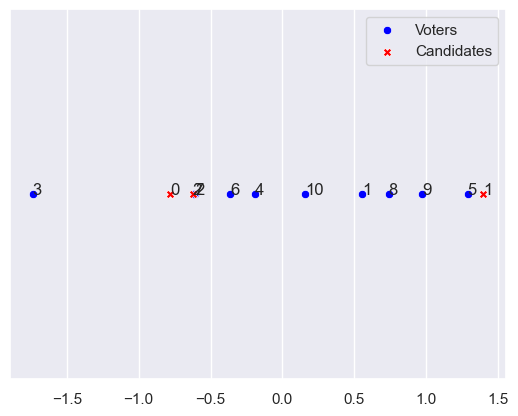

  Voter         0           1         2
-------  --------  ----------  --------
      1  0.409601  0.701499    0.499194
      2  0.985064  0.134075    0.999869
      3  0.631561  0.00729942  0.536467
      4  0.84108   0.282587    0.911294
      5  0.117851  0.993952    0.161155
      6  0.916604  0.212191    0.966762
      7  0.986561  0.131677    0.999974
      8  0.315344  0.804877    0.395555
      9  0.215175  0.91354     0.280011
     10  0.644023  0.463539    0.737257


In [4]:

voter_cov_matrix = generate_covariance(1, 1, 0)
cand_cov_matrix = generate_covariance(1, 1, 0)

sp = generate_spatial_profile(3, 10, 1,  cand_cov=cand_cov_matrix, voter_cov=voter_cov_matrix)

#sp.display()

sp.view(show_labels=True)

up = sp.to_utility_profile(utility_function = shepsle_utility)

up.display()

In [5]:
generate_covariance(1, 1, 0.2)

array([[1.]])

In [6]:
cand_clusters = [(np.array([0]), generate_covariance(1, 1, 0), 3)]

voter_clusters = [(np.array([-1]), generate_covariance(1, 1, 0), 3), (np.array([1]), generate_covariance(1, 1, 0), 3)]

sp = generate_spatial_profile_polarized(cand_clusters, voter_clusters)

sp.display()
#sp.view(show_labels=True)

sp.display()

[[-0.81403644]
 [-1.53872607]
 [ 0.30718558]]
[[ 0.48179361]
 [-1.14227807]
 [ 0.65923424]]
voter_samples  [-0.81403644 -1.53872607  0.30718558  0.48179361 -1.14227807  0.65923424]
{0: -1.2461038688428303, 1: -0.5001772588525556, 2: -0.12748923005452675} {0: -0.8140364428814126, 1: -1.5387260735919628, 2: 0.3071855824957195, 3: 0.48179360820696115, 4: -1.1422780724380925, 5: 0.6592342402006778}


TypeError: object of type 'numpy.float64' has no len()

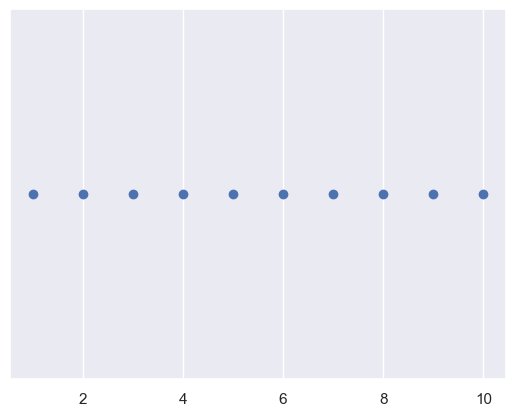

In [4]:
import matplotlib.pyplot as plt

# your data
x_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y_values = [1] * len(x_values)  # constant y value

plt.scatter(x_values, y_values)
plt.yticks([])  # this hides the y-axis
plt.show()


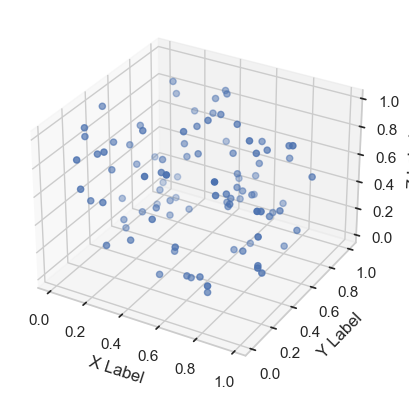

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generate some example data
np.random.seed(0)
n = 100
x = np.random.rand(n)
y = np.random.rand(n)
z = np.random.rand(n)

# Create a 3D scatterplot using matplotlib and seaborn
sns.set(style = "whitegrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [ ]:
    mean = [0] * num_dims  # mean is 0 for each dimension
    cov = np.diag([1] * num_dims)  # diagonal covariance

    _utility_fnc = utility_functions[utility_function]["func"]

    if utility_functions[utility_function]["param"] is not None or utility_function_param is not None: 
        util_parm = utility_function_param  if utility_function_param is not None else utility_functions[utility_function]["param"]
        utility_fnc = partial(_utility_fnc, util_parm)

    else: 
        utility_fnc = _utility_fnc

    # sample candidate/voter positions using a multivariate normal distribution
    cand_positions = np.random.multivariate_normal(np.array(mean), cov, num_cands)
    voter_positions = np.random.multivariate_normal(np.array(mean), cov, num_voters)



In [ ]:
import numpy as np
beta = 0.5

def are_almost_equal(num1, num2, epsilon=1e-15):
    return abs(num1 - num2) < epsilon

voter_positions = [[0.01, 0.01], [0.01, 0.25], [0.25, 0.01], [0.5, 0.5], [0.75, 0.25], [1, 1]]
cand_positions = [[0.01, 0.01], [0.01, 0.25], [0.25, 0.01], [0.5, 0.5], [0.75, 0.25], [1, 1]]

for v_pos in voter_positions:
    for c_pos in cand_positions:
        if not are_almost_equal(mixed_rm_utility(beta, np.array(v_pos), np.array(c_pos)), mixed_rm_utility_v2(beta, np.array(v_pos), np.array(c_pos))):

            print("v_pos = ", v_pos)
            print("c_pos = ", c_pos)
            print("mixed_rm_utility(beta, v_pos, c_pos) = ", round(mixed_rm_utility(beta, np.array(v_pos), np.array(c_pos)), 4))

            print("mixed_rm_utility_v2(beta, v_pos, c_pos) = ", round(mixed_rm_utility_v2(beta, np.array(v_pos), np.array(c_pos)), 4))
            print()




In [ ]:
uprof = generate_spatial_utility_profile(4, 5, utility_function="RM", utility_function_param=0.5)

uprof.display()

In [ ]:
from functools import partial

def rm_utility(beta, v_pos, c_pos):
    print(beta)
    print(v_pos)
    print(c_pos)


_utility_func = rm_utility

utility_func = partial(rm_utility, 1)

utility_func(3, 4)

In [ ]:
def generate_covariance(n_dimensions, std, rho):
    """
    Generates a covariance matrix for a multivariate normal distribution with the given standard deviation and correlation coefficient.

    Parameters
    ----------
    n_dimensions : int
        The number of dimensions.
    std : float
        The standard deviation.
    rho : float
        The correlation coefficient.

    Returns
    -------
    cov : numpy.ndarray
        The covariance matrix for a multivariate normal distribution.
    """
    assert std > 0, "Standard deviation must be positive"
    assert rho >= 0 and rho <= 1, "Correlation coefficient must be between 0 and 1"
    assert n_dimensions > 0, "Number of dimensions must be positive"

    cov = (std**2) * (np.eye(n_dimensions) + rho * (np.ones((n_dimensions, n_dimensions)) - np.eye(n_dimensions)))
    
    return cov

In [ ]:
print(generate_covariance(10, 1.0, -0.5))

In [ ]:
import numpy as np

# Set the means of the two dimensions
mean = np.array([0, 0])

# Set the standard deviations of the two dimensions
std_x = 1.0
std_y = 1.0

# Set the correlation coefficient
rho = 0.5

# Compute the covariance matrix
cov = np.array([[std_x**2, rho*std_x*std_y], 
                [rho*std_x*std_y, std_y**2]])

print(cov)

# Compute the standard deviations
std_devs = np.sqrt(np.diag(cov))

# Compute the correlation matrix
corr = cov / np.outer(std_devs, std_devs)

print(corr)

# Generate a sample from the bivariate normal distribution
sample = np.random.multivariate_normal(mean, cov, size=5)

print(sample)

In [ ]:
import numpy as np

# Assume we have a covariance matrix
cov = np.array([[1, 0.8], [0.8, 1]])

# Compute the standard deviations
std_devs = np.sqrt(np.diag(cov))

# Compute the correlation matrix
corr = cov / np.outer(std_devs, std_devs)

print(corr)

In [ ]:
uprof = UtilityProfile([{0:0.5, 1:0.5}, {0:1, 3:-1}, {}], domain=[0,1,2,3])

uprof.display()

print(uprof.write())

uprof2 = UtilityProfile.from_string(uprof.write())
uprof2.display()


In [ ]:

uprof = generate_spatial_utility_profile(4, 5)
uprof.display()

print(uprof.write())

uprof2 = UtilityProfile.from_string(uprof.write())
uprof2.display()

In [ ]:
def is_unique_plurality(prof): 

    for cands_to_remove in powerset(prof.candidates): 
        if len(cands_to_remove) < len(prof.candidates) - 1:
            reduced_prof, cmap = prof.remove_candidates(list(cands_to_remove))
            plurality_scores = reduced_prof.plurality_scores()
            p_scores = list(plurality_scores.values())
            if len(p_scores) != len(list(set(p_scores))): 
                return False
    return True


In [ ]:
uprof = generate_spatial_utility_profile(3, 4)

prof = uprof.to_ranking_profile().to_linear_profile()
prof.display()
is_unique_plurality(prof)


In [ ]:

import time

num_trials = 100

num_cands = 10
num_voters = 1000

irv_times = list()
ssv_times = list()

num = 0
for t in tqdm(range(num_trials)):
    uprof = generate_spatial_utility_profile(num_cands, num_voters)

    prof = uprof.to_ranking_profile().to_linear_profile()

    if is_unique_plurality(prof):
        num += 1
        s = time.time() 
        instant_runoff(prof)
        e = time.time()

        irv_times.append(e-s)

        s = time.time() 
        simple_stable_voting(prof)
        e = time.time()

        ssv_times.append(e-s)

print("Num unique plurality: ", num)
print("IRV: ", sum(irv_times)/len(irv_times))
print("SSV: ", sum(ssv_times)/len(ssv_times))

In [ ]:
uprof = generate_spatial_utility_profile(3, 4)

uprof.display()

us = uprof.utilities

for u in us: 
    print(f"3;nv;0:{u(0)};1:{u(1)};2:{u(2)};0:{u(0)};1:{u(1)};2:{u(2)};0:{u(0)};1:{u(1)};2:{u(2)}")

In [ ]:
num_trials = 1000

num_cands = 30
num_voters = 1000

irv_times = list()
ssv_times = list()

num = 0
for t in tqdm(range(num_trials)):
    prof = generate_profile(num_cands, num_voters, probmod="MALLOWS", probmod_param=0.4)


    if True or is_unique_plurality(prof):
        num += 1
        s = time.time() 
        instant_runoff(prof)
        e = time.time()

        irv_times.append(e-s)

        s = time.time() 
        stable_voting(prof)
        e = time.time()

        ssv_times.append(e-s)

print("Num unique plurality: ", num)
print("IRV: ", sum(irv_times)/len(irv_times))
print("SSV: ", sum(ssv_times)/len(ssv_times))

In [ ]:

prof = generate_profile(4, 15)

prof.display()


nprof2 = prof.anonymize()

nprof2.display()

nprof3 = Profile(prof.rankings)
nprof3.display()

nprof4 = nprof3.anonymize()

nprof4.display()

plurality.display(nprof4)
print(plurality.prob(nprof4))

print(nprof4.condorcet_winner())
condorcet_irv.display(nprof4)
condorcet_irv_put.display(nprof4)

In [ ]:
prof = Profile([[2, 0, 3, 1], [2, 3, 0, 1], [3, 1, 2, 0], [2, 1, 3, 0], [3, 0, 1, 2], [1, 2, 3, 0]], [1, 1, 1, 1, 1, 2])


prof.display()

prof.display_margin_graph()
print("split_cycle(prof) = ", split_cycle(prof))
print("split_cycle(prof, curr_cands = [1, 2]) = ", split_cycle(prof, curr_cands = [1, 2]))
print("split_cycle(prof.margin_graph(), curr_cands = [1, 2]) = ", split_cycle(prof.margin_graph(), curr_cands = [1, 2]))
print("split_cycle_Floyd_Warshall(prof.margin_graph(), curr_cands = [1, 2]) = ", split_cycle_Floyd_Warshall(prof.margin_graph(), curr_cands = [1, 2]))


In [ ]:
r = Ranking({1:2, 2:3})            
r2 = Ranking({1:1, 2:2})
r3 = Ranking({1:1})

[r, r2] == [r2, r3]


In [ ]:
prof = ProfileWithTies([{0:1, 1:2, 2:3}, {0:2, 1:1},  {2:1}], candidates=[0, 1, 2, 3])

prof.display()
prof.display_support_graph()

sg = prof.support_graph()



In [ ]:
prof = generate_truncated_profile(4, 55)
prof.display()
prof = generate_truncated_profile(4, 55, probmod="RT")
prof.display()


In [ ]:
for t in range(100): 
    num_cands = random.choice([1, 2, 3, 4, 5])
    num_voters = random.choice([1, 7, 10, 50, 1001])
    print(num_cands, num_voters)
    prof = generate_truncated_profile(num_cands, num_voters, probmod="IC")
    prof = generate_truncated_profile(num_cands, num_voters, probmod="RT")

In [ ]:
prof = ProfileWithTies([{0:1, 1:2, 2:3}, {0:2, 1:1},  {2:1}], candidates=[0, 1, 2, 3])

prof.display()

for r in prof.rankings:
    print(r)
    print(r.to_linear())

print(prof.to_linear_profile())

prof = ProfileWithTies([{0:1, 1:2, 2:3}, {0:2, 1:1, 2:3},  {2:1, 3:2, 0:3}], candidates=[0, 1, 2, 3])

prof.display()

for r in prof.rankings:
    print(r)
    print(r.to_linear())

print(prof.to_linear_profile())

prof = ProfileWithTies([Ranking({0:1, 1:2, 2:3}), {0:2, 1:1, 2:3},  {1:1, 2:2, 0:3}])

prof.display()

for r in prof.rankings:
    print(r)
    print(r.to_linear())

print(prof.to_linear_profile())




In [ ]:
get_cands = lambda r: list(r.keys()) if type(r) == dict else r.cands
rtest = [Ranking({0:1, 1:2, 2:3}), {0:2, 1:1, 2:3},  {1:1, 2:2, 3:3}]

for r in rtest:
    if type(r) == dict: 
        print(list(r.keys()))
    else:
        print(r.cands)

print([get_cands(r) for r in rtest])

In [ ]:
prof.display()

n_prof = prof.add_unranked_candidates()

n_prof.display()

In [ ]:
prof.plurality_scores(curr_cands = [0])

In [ ]:
plurality_with_runoff.display(prof)

In [ ]:
plurality.display(prof)

In [ ]:
print(borda_for_profile_with_ties(prof, borda_scores=symmetric_borda_scores))
print(borda_for_profile_with_ties(prof, borda_scores=domination_borda_scores))
print(borda_for_profile_with_ties(prof, borda_scores=weak_domination_borda_scores))
print(borda_for_profile_with_ties(prof, borda_scores=non_domination_borda_scores))

In [ ]:
for t in range(100): 
    prof = generate_profile(4, 11)  
    print(split_cycle(prof)  ) 

In [ ]:

for t in range(100):
    for vm in [split_cycle, 
               stable_voting, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               simple_stable_voting, 
               iterated_split_cycle,
               copeland,
               borda, 
               plurality, 
               plurality_with_runoff, 
               instant_runoff, 
               coombs, 
               minimax, 
               strict_nanson, 
               bucklin]: 

        prof = generate_profile(5, 11)

        vm.display(prof)
        
        prof = generate_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()




In [ ]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               plurality,
               stable_voting, 
               simple_stable_voting, 
               copeland,
               borda_for_profile_with_ties,
               instant_runoff_for_truncated_linear_orders
               ]: 

        prof = generate_truncated_profile(5, 11)

        vm.display(prof)
        prof = generate_truncated_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


In [ ]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               stable_voting, 
               simple_stable_voting, 
               gocha,
               smith_set,
               copeland
               ]: 

        mg = generate_margin_graph(5)

        vm.display(mg)
        mg = generate_edge_ordered_tournament(4)
        vm.display(mg)

        mg = generate_edge_ordered_tournament_infinite_limit(5)
        vm.display(mg)


        ws_restricted = vm(mg, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


In [ ]:
for t in range(100):
    for um in [sum_utilitarian,
                relative_utilitarian,
                maximin,
                lexicographic_maximin,
                nash,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        print(um(uprof))

        uprof = generate_utility_profile_normal(6, 20)
        print(um(uprof))

        uprof = generate_spatial_utility_profile(5, 11)
        print(um(uprof))

    print()


In [ ]:
for t in range(100):
    for vm in [sum_utilitarian_ws,
                relative_utilitarian_ws,
                maximin_ws,
                lexicographic_maximin_ws,
                nash_ws,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        vm.display(uprof)

        uprof = generate_utility_profile_normal(6, 20)
        vm.display(uprof)

        uprof = generate_spatial_utility_profile(5, 11)
        vm.display(uprof)

        ws_restricted = vm(uprof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()
